In [37]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [67]:
def comparison_heatmap(adata, key1, key2, label_1=None, label_2=None, cmap = 'Reds', annot = True):
    if label_1==None:
        label_1=key1
    if label_2==None:
        label_2=key2
    expected_df = adata.obs[[key1,key2]].groupby(by=[key2,key1]).size().reset_index(name = 'count')
    counts = np.array(expected_df['count'].tolist())
    df = pd.DataFrame(counts.reshape(((len(adata.obs[key2].cat.categories),len(adata.obs[key1].cat.categories)))), index = expected_df[key2].unique(), columns = expected_df[key1].unique())
    if annot ==True:
        annot_ = df.astype(int)
        sc.settings.set_figure_params(figsize=('17', '17'), color_map='gist_earth')
    else:
        annot_=None
        sc.settings.set_figure_params(figsize=('7', '7'), color_map='gist_earth')
    s = sns.heatmap(df/np.sum(df,axis = 0), cbar_kws={'label': '% cell shared between annotations'}, cmap=cmap, vmax=1, vmin=0, annot = annot_,  fmt='.7g')
    s.set_ylabel(label_2, fontsize=12)
    s.set_xlabel(label_1, fontsize = 12)
    return df


In [40]:
import sys 
from deepscore import deepscore
from deepscore import marker_analysis

In [41]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('15', '10'), color_map='gist_earth')

In [42]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',

'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#808080',
 'Unknown':'#000000',
'Low_Quality_RNA':'#808080'}

In [51]:
sample_color_dic = {'lib_09': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lib_10': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'lib_15': (1.0, 0.4980392156862745, 0.054901960784313725),
 'lib_23': (1.0, 0.7333333333333333, 0.47058823529411764),
 'lib_29': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'lib_34': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'lib_36': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'lib_38': (1.0, 0.596078431372549, 0.5882352941176471),
 'lib_51': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'lib_54': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'lib_55': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'lib_56': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'lib_57': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

In [ ]:
adata = sc.read('objects/atac_clusters.h5ad')

# ADDING RNA LT ANNOTATION

In [ ]:
adata_rna = sc.read('../RNA/objects/Integration_scVI_Final.h5ad')
adata_rna = adata[adata.obs['batch'].isin(['snRNA'])]
adata_rna.index = [i.replace('-snRNA','') for i in adata_rna.index]
adata_rna = adata_rna[adata_rna.obs.index.isin(adata.obs.index)][adata[adata.obs.index.isin(adata_rna.obs.index)].obs.index]
adata = adata[adata.obs.index.isin(adata_rna.obs.index)]
adata.obs['Deepscore_external_RNA'] = adata_rna.obs['Deepscore_external']

# ADDING DOUBLETS INFORMATOIN

In [77]:
sample_list = []
for s in os.listdir('../../../data/'):
    if s.startswith('lib_'):
        sample_list.append(s)
sample_list

['lib_09',
 'lib_55',
 'lib_54',
 'lib_34',
 'lib_15',
 'lib_29',
 'lib_56',
 'lib_23',
 'lib_38',
 'lib_36',
 'lib_51',
 'lib_57',
 'lib_10']

In [95]:
values = []
for i in sample_list:
    df = pd.read_csv(f'AMULET_outs/{i}/MultipletBarcodes_01.txt', sep='\t', header=None)
    values += list(df[0])

In [119]:
boll_l=  pd.DataFrame([i in values for i in adata.obs.index], columns = ['AMULET_doublets'], dtype='category')

In [126]:
adata.obs['AMULET_doublets']

AAACAGCCAACACCTA-3     False
AAACAGCCAAGCTTAT-1     False
AAACAGCCAAGGCCAA-13    False
AAACAGCCAATAACGA-13    False
AAACAGCCAATCCCTT-4     False
                       ...  
TTTGTTGGTTTAGTCC-13    False
TTTGTTGGTTTATTCG-6     False
TTTGTTGGTTTCCGGC-3     False
TTTGTTGGTTTCCTCC-11    False
TTTGTTGGTTTCCTCC-7     False
Name: AMULET_doublets, Length: 75013, dtype: bool

In [124]:
adata.obs['AMULET_doublets'] = boll_l['AMULET_doublets'].tolist()

In [127]:
adata.obs['AMULET_doublets'] = adata.obs['AMULET_doublets'].astype('category')

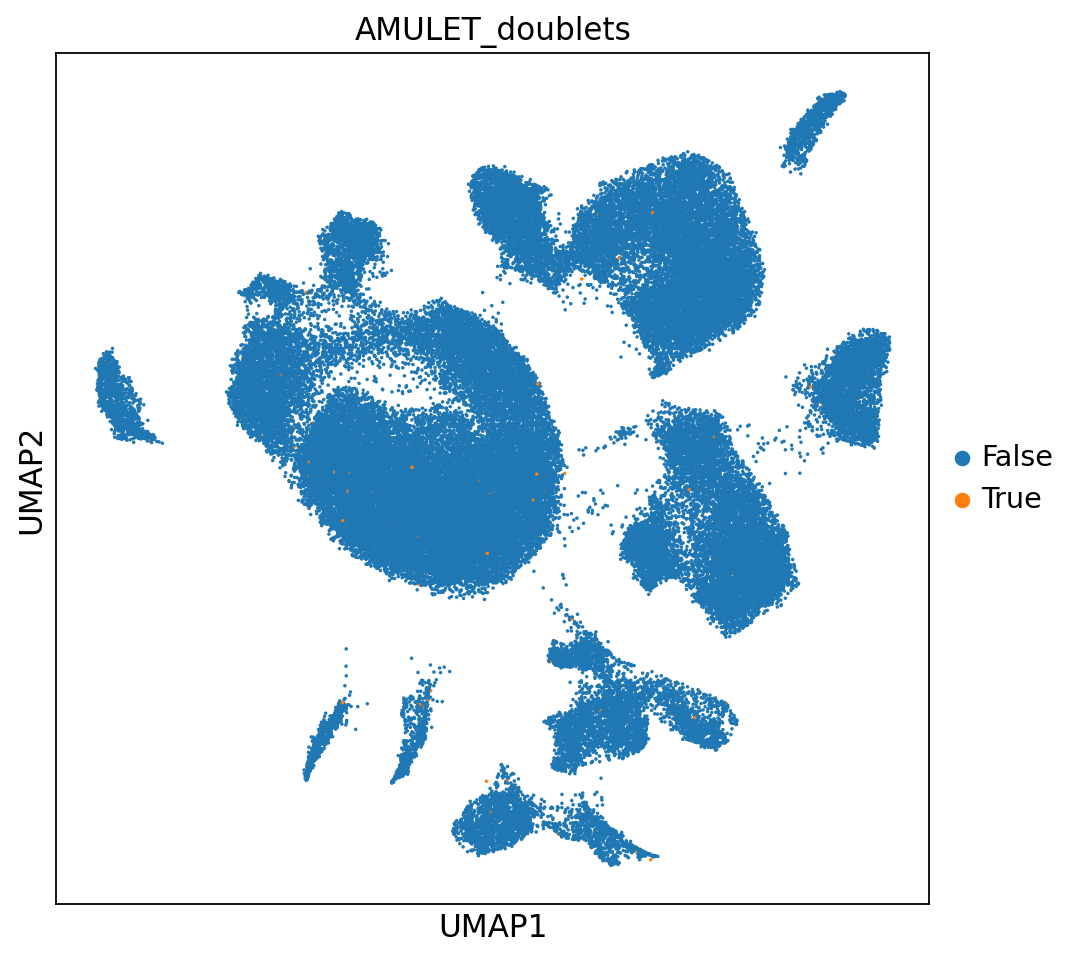

In [133]:
sc.pl.umap(adata, color=['AMULET_doublets'], size = 10)

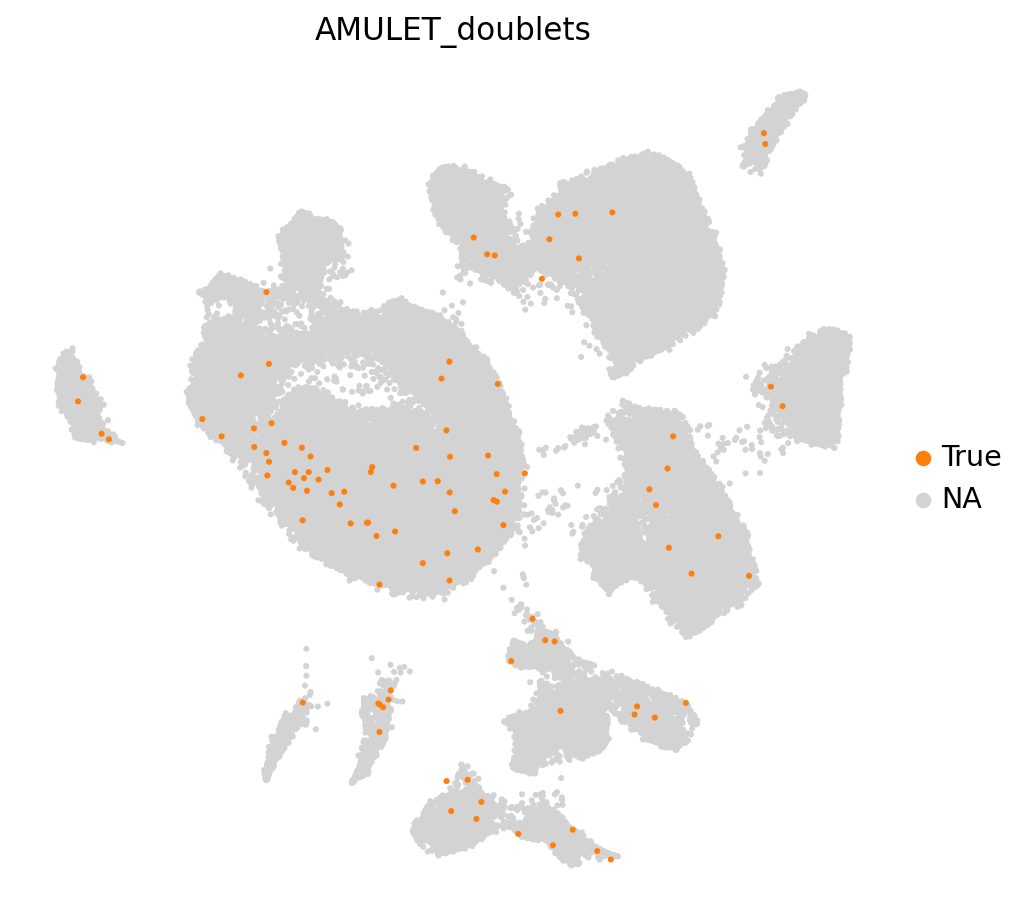

In [138]:
sc.pl.umap(adata, color=['AMULET_doublets'], size = 30, groups=[True],frameon = False)

In [ ]:
adata.write('objects/atac_annotation.h5ad', compression='gzip')